# SK Part 4: Model Evaluation


## Learning Objectives

The objective of this tutorial is to illustrate evaluation of machine learning algorithms using various performance metrics. We shall use the following datasets as examples of binary classification, multinomial (a.k.a. multiclass) classification, and regression problems respectively:

1. [Breast Cancer Wisconsin Data](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29). The target feature is binary, i.e., if a cancer diagnosis is "malignant" or "benign".
2. [Wine Data](https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data). The target feature is multinomial. It consists of three classes of wines in a particular region in Italy.
3. [Boston Housing Data](https://archive.ics.uci.edu/ml/machine-learning-databases/housing/). The target feature is continuous, which is the house prices in Boston in 1970's.

## Table of Contents

* [Why Evaluation?](#why)
* [Evaluation Procedures](#procedures)
* [Choosing the Right Metric(s)](#metrics)
* [Evaluating Binary Classifiers](#classifiers)
    - [Getting Started](#classifiers_started)
    - [Confusion Matrix](#cmatrix)
    - [Precision, Recall, and F1 Measures](#c_report)
    - [Profit Matrix](#profit_matrix)
    - [ROC Curves](#roc)
* [Evaluating Multinomial Classifiers](#mn_classifiers)
    - [Getting Started](#mn_classification_started)
    - [Multinomial Evaluation Metrics](#mn_eval)
* [Evaluating Regressors](#regression)
    - [Getting Started](#regression_started)
    - [Evaluating Multiple Regression Models](#regression_multiple_models)
    - [MAE and R-Squared Metrics](#regression_metrics)
    - [Residual Analysis (Optional)](#regression_residuals)
* [Beyond Evaluation](#beyond)
* [Exercises](#exercises)

## Why Evaluation? <a class="anchor" id="why"></a> 

Model evaluation is a necessary step in machine learning in order to accomplish the following:

* Determine the "best" model
* Estimate how the models will perform when deployed
* Convince the end-users that the deployed model meets their needs

There are two major considerations in evaluation:

1. How shall we split the data for evaluation?
2. Which metric(s) should we use for evaluation?

## Evaluation Procedures <a class="anchor" id="procedures"></a> 

With respect to the first consideration, we can split the dataset into a training set and a test set (also known as hold-out-sampling). Then we build a machine learning model on the training set and we evaluate how well the model performs on the test set. Data splitting is crucial to avoid or at least mitigate the issue of overfitting. 

A more robust and methodical approach to hold-out sampling is cross-validation. Also, another extension of cross-validation is repeated cross-validation (say 3 times) where data is partitioned into 5 (or sometimes 10) equal-sized chunks multiple times and the cross-validation procedure is repeated, each time with a different partitioning of data.


## Choosing the Right Metric(s) <a class="anchor" id="metrics"></a> 

The second consideration is to choose the right metric(s), which is almost always problem-specific. Suppose the problem is a binary classification problem: either a patient is sick or healthy in a medical diagnosis setting. We want to predict a sick patient to be sick and, apparently we would never want to predict a sick patient to be healthy. However, there is no such thing as a perfect model and there is always some sort of trade-off involved. We can increase the cutoff threshold for scores to increase the chances of predicting a truly sick patient as sick, which would be increasing the true positive rate (TPR) (i.e., the recall). But there is no free lunch! Increasing TPR will probably lead to an increase in false positive rate (FPR) as well, i.e., predicting a healthy patient to be sick (a.k.a. false alarms). We discuss this issue of finding the "sweet balance" between TPR and FPR further below.

Commonly used evaluation metrics for a binary classifier are as follows:

* Simple classification accuracy,
* Average class accuracy (using either arithmetic or harmonic mean),
* Confusion matrix,
* Area under ROC curve (AUC), and
* Classification report.

Some of the binary evaluation metrics can be extended to multinomial classification problems with some caveats. Meanwhile, evaluating a regressor is simpler. We do not need to adjust prediction score (in fact, we cannot). Popular metrics for regression are as follows:

* Root mean squared error (RMSE),
* R-squared ($R^2$), and 
* Mean absolute error (MAE).

Please refer to `Scikit-Learn` documentation on [evaluation methods](https://scikit-learn.org/stable/modules/model_evaluation.html) for more details.

## Evaluating Binary Classifiers  <a class="anchor" id="classifiers"></a> 

### Getting Started <a class="anchor" id="classifiers_started"></a> 

Let's load the Breast Cancer Wisconsin dataset and let's split the descriptive features and the target feature into a training set and a test set by a ratio of 70:30. That is, we use 70 % of the data to build a KNN classifier and evaluate its performance using the test set. 

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
from sklearn import preprocessing

cancer_df = load_breast_cancer()
Data, target = cancer_df.data, cancer_df.target

Data = preprocessing.MinMaxScaler().fit_transform(Data)

# target is already encoded, but we need to reverse the labels
# so that malignant is the positive class
target = np.where(target==0, 1, 0)

D_train, D_test, t_train, t_test = train_test_split(Data, 
                                                    target, 
                                                    test_size = 0.3, 
                                                    random_state=8)

We shall utilize cross-validation to find the optimal KNN parameters (please refer to the **SK Part 3** notebook for more details on hyperparameter tuning). Here, we use a 3-repeated 5-fold stratified cross-validation on the training set. We choose accuracy as our performance metric. In `Scikit-Learn`, a performance metric is called a "score". The accuracy rate is defined as

$$\text{Accuracy rate} = \frac{\text{Number of correct predictions}}{\text{Total predictions}}$$

Note that 1 - accuracy rate is called the misclassification rate, that is, 

$$\text{Misclassification rate} = \frac{\text{Number of incorrect predictions}}{\text{Total predictions}}$$


In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV

cv_method = RepeatedStratifiedKFold(n_splits=5, 
                                    n_repeats=3, 
                                    random_state=8)

Using the grid search, we determine the optimal KNN parameters.

In [3]:
model_KNN = KNeighborsClassifier()
params_KNN = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7], 
              'p': [1, 2, 5]}

gs_KNN = GridSearchCV(estimator=model_KNN, 
                      param_grid=params_KNN, 
                      cv=cv_method,
                      verbose=1, 
                      scoring='accuracy',
                      return_train_score=True)

In [4]:
gs_KNN.fit(D_train, t_train);

Fitting 15 folds for each of 21 candidates, totalling 315 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 315 out of 315 | elapsed:    9.5s finished


Let's get the predictions for the test data.

In [5]:
t_pred = gs_KNN.predict(D_test)

Scikit Learn has a module named `metrics` which contains different performance metrics for classifers and regressors. The example below shows how to calculate accuracy score on the test data. 

In [6]:
from sklearn import metrics
metrics.accuracy_score(t_test, t_pred)

0.9649122807017544

In general, a score function has two arguments:

* `y_true`: the actual values. In our example,  `y_true = t_test` (the actual target values from the test data).
* `y_pred`: the predicted values. In our example, `y_pred = t_pred` (the predicted value from the test data).

### Confusion Matrix <a class="anchor" id="cmatrix"></a> 

A confusion matrix is a square matrix $M$ constructed such that $M_{i,j}$ is equal to the number of observations known to be in group $i$ but predicted to be in group $j$. For a binary classifier, 

* $M_{0,0}$ = True negatives (TN)
* $M_{1,0}$ = False negative (FN)
* $M_{1,1}$ = True positives (TP)
* $M_{0,1}$ = False positives (FP)

Above, we start the matrix index from 0 because Python indices start from 0. A confusion matrix for a binary classification problem can be shown as a table as below.

| Target | Predicted Negative | Predicted Positive |
|----|----|----|
| Target Negative: | True Negative (TN) | False Positive (FP) |
| Target Positive: | False Negative (FN) | True Positive (TP) |

Let's calculate the confusion matrix for the KNN model.

In [7]:
metrics.confusion_matrix(t_test, t_pred)

array([[104,   1],
       [  5,  61]])

**Exercise**

1. Calculate true positive rate (TPR), which is defined as TP/(TP + FN).
2. Calculate false negative rate (FNR), which is defined as FN/(TP + FN).

### Precision, Recall, and F1 Measures  <a class="anchor" id="c_report"></a> 

Precision, recall, and F1 measures are commonly used metrics for binary classification problems. There are two ways to obtain these measures. The first way is to use the functions from `metrics` below:

* `metrics.precision_score(y_true, y_pred)`
* `metrics.recall_score(y_true, y_pred)`
* `metrics.f1_score(y_true, y_pred)`

Another way is to use the `classification_report` which will report these measures.

In [8]:
print(metrics.classification_report(t_test, t_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       105
           1       0.98      0.92      0.95        66

    accuracy                           0.96       171
   macro avg       0.97      0.96      0.96       171
weighted avg       0.97      0.96      0.96       171



**Refresher Questions**: 

1. Recall is equivalent to TPR. Does the value reported by `classification_report` match with the confusion matrix?
2. Is the F1 score reported by `classification_report` correct? Hint: F1 $ = 2\times\frac{\text{precision}\times\text{recall}}{\text{precision}+\text{recall}}$

So, is simple accuracy the correct measure in breast cancer classification? Most probably not. If you are a medical practitioner, you might want to increase **TPR** where malignant is the positive class and benign is the negative class. In `Scikit-Learn`, the positive class must be denoted by 1 and the negative class must be denoted by 0. However, in the original dataset, the target response is encoded as

$$\text{Target} = \begin{cases}1 & \text{ if benign }\\ 0 & \text{ if malignant }\end{cases}$$

So, we need to be very careful how we define the positive and negative classes in a binary classification problem like this. For this reason, we used the `np.where()` function above to revert the labels so that the positive class is denoted by 1 and the negative class is denoted by 0. After reversing the labels, we now have

$$\text{Target} = \begin{cases}0 & \text{ if benign }\\ 1 & \text{ if malignant }\end{cases}$$

Let's retrain a KNN model using recall (TPR) as the performance metric. 

In [9]:
D_train, D_test, t_train, t_test = train_test_split(Data, target, test_size = 0.3, random_state=8)

perf_metric = 'recall' # some other options are: accuracy, f1, roc_auc, etc.

gs_KNN = GridSearchCV(estimator=model_KNN, 
                      param_grid=params_KNN, 
                      cv=cv_method,
                      verbose=1, 
                      scoring=perf_metric,
                      return_train_score=True)

gs_KNN.fit(D_train, t_train);

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 15 folds for each of 21 candidates, totalling 315 fits


[Parallel(n_jobs=1)]: Done 315 out of 315 | elapsed:    9.7s finished


In [10]:
t_pred = gs_KNN.predict(D_test)
metrics.recall_score(t_test, t_pred)

0.9242424242424242

In [11]:
metrics.confusion_matrix(t_test, t_pred)

array([[104,   1],
       [  5,  61]])

For this specific problem, F1 or AUC metrics can be good alternatives to accuracy or TPR since there is a mild class imbalance problem here: we have more benign classes than malignant classes (357 vs. 212 counts).

### Profit Matrix <a class="anchor" id="profit_matrix"></a> 

In many cases, it is incorrect to treat all outcomes equally. Sometimes we need to impose asymmetric gains for correct predictions and asymmetric costs for incorrect predictions. For instance, suppose the following is our profit matrix:

|  Predicted Negative  |  Predicted Positive  |
|----|----|
| 0 for True Negative (TN)  | -10 False Positive (FP) |
| -50 for False Negative (FN) | 100 True Positive (TP) |

Notice that we allocate more cost to false negatives than to false positives. Next we shall calculate the **overall** profit using the profit and confusion matrices. Let's create the profit matrix using `NumPy`.

In [12]:
profit_matrix = np.array([[0, -10], [-50, 100]])

In [13]:
profit_matrix

array([[  0, -10],
       [-50, 100]])

In [14]:
confusion_matrix = metrics.confusion_matrix(t_test, t_pred)
confusion_matrix

array([[104,   1],
       [  5,  61]])

The overall profit matrix is calculated as element-wise multiplication of the profit and confusion matrices.

In [15]:
overall_profit_matrix = profit_matrix*confusion_matrix
overall_profit_matrix

array([[   0,  -10],
       [-250, 6100]])

The net profit (or loss) is given by the sum of the elements of the overall profit matrix.

In [16]:
np.sum(overall_profit_matrix)

5840

### ROC Curves <a class="anchor" id="roc"></a> 

In the previous section, we saw how the TPR and TNR are calculated from a confusion matrix. As explained in Chapter 8 of our textbook, these measures are tied to the threshold used to convert probability scores to predictions. By default, `Scikit-Learn` models predict on the data based on a threshold value of 0.5. If we change the threshold, the confusion matrix will also change. For instance, as the threshold decreases, both TPR and FPR increase. The opposite holds when the threshold increases. To capture this trade-off, we use ROC (Receiver Operating Characteristic) curves. For instance, decreasing the score threshold would be moving to the right on the ROC curve. The area under the ROC curve (AUC) together with the F1 score are some of the most popular metrics for evaluating binary classifiers as they are robust to the class imbalance issue in general.

In `Scikit-Learn`, a quick way to get AUC is to use `metric.roc_auc_score`. But first we will retrain the model with AUC as our performance metric.

In [17]:
perf_metric = 'roc_auc'

gs_KNN = GridSearchCV(estimator=model_KNN, 
                      param_grid=params_KNN, 
                      cv=cv_method,
                      verbose=1, 
                      scoring=perf_metric,
                      return_train_score=True)

gs_KNN.fit(D_train, t_train);

metrics.roc_auc_score(t_test, t_pred)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 15 folds for each of 21 candidates, totalling 315 fits


[Parallel(n_jobs=1)]: Done 315 out of 315 | elapsed:    7.3s finished


0.9573593073593074

We can visualize an ROC curve by calculating prediction scores using the `predict_proba` method in `scikit-learn`.

In [18]:
t_prob = gs_KNN.predict_proba(D_test)
t_prob[0:10]

array([[1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.83333333, 0.16666667],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ]])

As a side note, `_proba` stands for "probability", which is apparently between 0 and 1. Now let's visualize the ROC curve.

In [19]:
fpr, tpr, _ = metrics.roc_curve(t_test, t_prob[:, 1])
roc_auc = metrics.auc(fpr, tpr)
roc_auc

0.9671717171717172

In [20]:
import pandas as pd
df = pd.DataFrame({'fpr': fpr, 'tpr': tpr})
df

,fpr,tpr
0,0.000000,0.000000
1,0.000000,0.757576
2,0.009524,0.893939
3,0.019048,0.909091
4,0.076190,0.939394
5,0.114286,0.939394
6,0.228571,0.954545
7,1.000000,1.000000


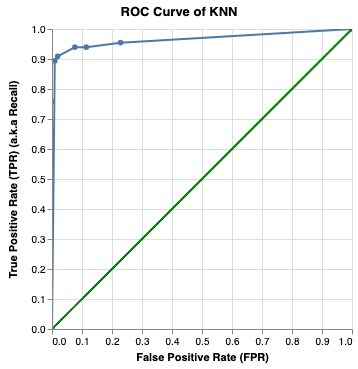

In [21]:
import altair as alt

base = alt.Chart(df, 
                 title='ROC Curve of KNN'
                ).properties(width=300)

roc_curve = base.mark_line(point=True).encode(
    alt.X('fpr', title='False Positive Rate (FPR)',  sort=None),
    alt.Y('tpr', title='True Positive Rate (TPR) (a.k.a Recall)'),
)

roc_rule = base.mark_line(color='green').encode(
    x='fpr',
    y='fpr',
    size=alt.value(2)
)

(roc_curve + roc_rule).interactive()

Our ROC curve has an "elbow" around FNR = 0.1 with a very high corresponding TPR. This indicates the optimized KNN model has an outstanding predictive performance!

## Evaluating Multinomial Classifiers <a class="anchor" id="mn_classifiers"></a> 

Multinomial classification refers to prediction problems where the target feature is multinomial (a.k.a. multiclass). That is, the target feature is categorical with at least three different levels. For multinomial classification illustration, we use the [Wine Data](https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data). The target feature refers to three different classes of wines in a particular region in Italy. Although multinomial classification is a generalization of the binary case, we cannot use the following binary metrics to evaluate a multinomial classifier:

* `metrics.roc_auc_score`.
* `metrics.average_precision_score`

Some other metrics can be applied to multinomial targets, but they require an "average" parameter as discussed below.

### Getting Started  <a class="anchor" id="mn_classification_started"></a> 

Let's load up the wine data and split it into 70% training and 30% test data. We shall use 3-repeated 5-fold cross-validation to determine optimal hyperparameters of a KNN model using the training set. Then we shall evaluate the model's performance on the test set.

In [22]:
from sklearn.datasets import load_wine

wine = load_wine()
Data, target = wine.data, wine.target

Let's check class counts.

In [23]:
np.unique(wine.target, return_counts = True)

(array([0, 1, 2]), array([59, 71, 48]))

We shall optimize the KNN hyperparameters based on the simple accuracy score. 

In [24]:
D_train, D_test, t_train, t_test = train_test_split(Data, 
                                                    target, 
                                                    test_size=0.3, 
                                                    stratify=target,
                                                    random_state=8)

model_KNN = KNeighborsClassifier()
params_KNN = {'n_neighbors': [2, 3, 4, 5, 6, 7], 
              'p': [1, 2, 5]}

gs_KNN = GridSearchCV(estimator=model_KNN, 
                      param_grid=params_KNN, 
                      cv=cv_method,
                      verbose=1, 
                      scoring='accuracy', 
                      return_train_score=True)

gs_KNN.fit(D_train, t_train);

Fitting 15 folds for each of 18 candidates, totalling 270 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:    1.4s finished
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


### Multinomial Evaluation Metrics <a class="anchor" id="mn_eval"></a>  

The accuracy of the KNN model on the test data can be calculated as follows.

In [25]:
from sklearn import metrics

t_pred = gs_KNN.predict(D_test)
metrics.accuracy_score(t_test, t_pred)

0.7222222222222222

How about the confusion matrix? Clearly, it will be a 3 x 3 square matrix.

In [26]:
metrics.confusion_matrix(t_test, t_pred)

array([[15,  1,  2],
       [ 2, 16,  3],
       [ 0,  7,  8]])

As in binary classification problems, we can also generate a classification report.

In [27]:
print(metrics.classification_report(t_test, t_pred))

              precision    recall  f1-score   support

           0       0.88      0.83      0.86        18
           1       0.67      0.76      0.71        21
           2       0.62      0.53      0.57        15

    accuracy                           0.72        54
   macro avg       0.72      0.71      0.71        54
weighted avg       0.72      0.72      0.72        54



In the classification report, "micro" averaging refers to calculating metrics globally by counting the total true positives, false negatives, and false positives. On the other hand, "macro" averaging refers to calculating metrics for each label, and find their unweighted mean. Macro averaging does not take label imbalance into account. Thus, micro averaging would be preferred to macro when there is a class imbalance. Likewise, if the class counts are somewhat balanced as in the wine data example, micro and macro averaging results will be similar. Also, the micro F1 score is the harmonic mean of micro recall and micro precision. To obtain micro scores, we set `average='micro'` as below.

In [28]:
metrics.recall_score(t_test, t_pred, average='micro')

0.7222222222222222

In [29]:
metrics.precision_score(t_test, t_pred, average='micro')

0.7222222222222222

In [30]:
metrics.f1_score(t_test, t_pred, average='micro')

0.7222222222222222

Finally, we can calculate the "average class accuracy using arithmetic mean" by using the `balanced_accuracy_score` method. This metric can be used for both binary as well as multinomial classification problems.

In [31]:
metrics.balanced_accuracy_score(t_test, t_pred)

0.7095238095238096

## Evaluating Regressors <a class="anchor" id="regression"></a>  

### Getting Started <a class="anchor" id="regression_started"></a>  

Let's load up the Boston housing data. Then we split the data into training and test sets.

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_boston
from sklearn import preprocessing

housing_df = load_boston()
Data, target = housing_df.data, housing_df.target

# scale each descriptive feature to be between 0 and 1
Data = preprocessing.MinMaxScaler().fit_transform(Data)

D_train, D_test, t_train, t_test = train_test_split(Data, target, test_size = 0.3, random_state=999)

We choose mean squared error (MSE) for model performance evaluation and comparison. The MSE is defined as

$$\text{MSE} = \frac{\sum_{i=1}^{n}(t_{i} - \mathbb{M}(d_{i})^2)}{n}$$

where

* $t_{1}, t_{2}, ..., t_{n}$ is the set of $n$ actual target values (in our case, housing prices) from the test data.
* $\mathbb{M}$ is the model we train and $\mathbb{M}(d_{i})$ is the model's prediction for observation $d_i$ in the test data.

As in classification problems, it is recommended to use the same performance metric for model evaluation and hyperparameter tuning. We determine the optimal parameters using a 3 repeated 5-folded cross validation. Keep in mind that stratification will not work with regression problems as there is nothing to stratify on as in classification problems!

In [33]:
from sklearn.model_selection import RepeatedKFold, GridSearchCV
cv_method = RepeatedKFold(n_splits=5, n_repeats=3, random_state=999)

### Evaluating Multiple Regression Models <a class="anchor" id="regression_multiple_models"></a> 

Unlike the previous classification problem, we shall illustrate how we can evaluate **two** models simultaneously within the same cross validation strategy. 

First, we need to import the modules required to build a KNN and a DT model.

In [34]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn import tree

Second, we create a dictionary called `models` as follows: each dictionary key corresponds to a different model and the dictionary values are the model objects. For example, the first key is `KNN` with a value of ` KNeighborsRegressor()`. 

In [35]:
models = {'KNN': KNeighborsRegressor(),
          'DT': tree.DecisionTreeRegressor()}

Third, we create a dictionary named `models_parameters` which **must share the same keys** as in `models` dictionary. In `models_parameters`, each item contains its own dictionary of parameters we would like to optimize. For instance, `KNN` has a dictionary consisting of `n_neighbors` and `p` keys. Within this dictionary, each item has the range of parameter values that we would like to try.

In [36]:
models_parameters = {'KNN': {'n_neighbors': [1, 2, 3, 4, 5], 
                             'p': [1, 2, 3]},
                     'DT': {'max_depth': [2, 3, 4], 
                            'min_samples_split': [2, 3, 4, 5]}}

Fourth, we need to create a `GridSearchCV` object where we specify `estimator=models` and `param_grid=models_parameters` to tell `GridSearchCV` the models and their corresponding parameters we wish to build and train. 

We define `scoring='neg_mean_squared_error'` as the regression performance metric we want to use. The convention in `scikit-learn` is that when it comes to scores, "higher is always better". Thus, whenever we would like to use a metric for which lower values are better (such as MSE), we need to use their negatives as the score so that we are compliant with the convention that "higher score is better". The reason is that maximizing the negative of MSE will actually minimize the MSE. For instance, in order to minimize MAE, we would define `scoring='neg_mean_absolute_error'`.


For each model, we determine the optimal set of parameters that result in the lowest MSE as possible. Please remember to include `cv_method` (the cross-validation strategy we defined) in `GridSearchCV`.

Finally, we run the grid search in a loop. We create a dictionary named `fitted_models` to store the grid search outputs. 

In [37]:
fitted_models = {} # this creates an empty dictionary
for m in models: # this will loop over the dictionary keys
    print(f'\nHyperparameter tuning for {m}:')
    gs = GridSearchCV(estimator=models[m], 
                      param_grid=models_parameters[m], 
                      cv=cv_method,
                      verbose=1, 
                      scoring='neg_mean_squared_error')
    gs.fit(D_train, t_train);
    fitted_models[m] = gs
    print(f'Best {m} model: {gs.best_params_}')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Hyperparameter tuning for KNN:
Fitting 15 folds for each of 15 candidates, totalling 225 fits


[Parallel(n_jobs=1)]: Done 225 out of 225 | elapsed:    0.6s finished
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best KNN model: {'n_neighbors': 2, 'p': 1}

Hyperparameter tuning for DT:
Fitting 15 folds for each of 12 candidates, totalling 180 fits
Best DT model: {'max_depth': 4, 'min_samples_split': 4}


[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:    0.2s finished
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


To compare KNN and DT models, we predict housing prices from the test data and compute the MSE (via `mean_squared_error(<true target value>, <predicted target value>)` from `metrics`) as below.

In [38]:
from sklearn import metrics
for m in fitted_models:
    t_pred = fitted_models[m].predict(D_test)
    mse = metrics.mean_squared_error(t_test, t_pred)
    print(f'MSE of {m} is: {mse}')

MSE of KNN is: 15.997105263157895
MSE of DT is: 19.197963670478213


KNN has a lower test MSE error compared to DT, implying (optimized) KNN is more accurate in predicting the housing price.

### MAE and R-Squared Metrics <a class="anchor" id="regression_metrics"></a> 

Besides MSE, we can compute other metrics:

* Mean Absolute Error (MAE) which is more robust to outliers. This can be calculated via `metrics.mean_absolute_error`.
* $R^{2}$, a domain-independent measure of error. This metric measures the amount of variability in the target feature that is explained by the descriptive features. It is between 0 and 1 with higher values being better. It can be calculated via `r2_score`.

Let's check whether KNN still outperforms DT if we evaluate them using MAE or $R^{2}$.

In [39]:
from sklearn import metrics
for m in fitted_models:
    t_pred = fitted_models[m].predict(D_test)
    mae = metrics.mean_absolute_error(t_test, t_pred)
    r2 = metrics.r2_score(t_test, t_pred)
    print(f'MAE and r-squared {m} are: {mae}, {r2}')

MAE and r-squared KNN are: 2.7947368421052627, 0.7916844989356551
MAE and r-squared DT are: 3.1298498895188422, 0.7500026813825382


KNN has a lower test MAE error and a higher $R^{2}$ than DT. Thus, KNN outperforms DT with respect to these two metrics as well. In practice though, using a different metric during hyperparameter tuning will likely result in a different model evaluation. Recall that we used MSE to optimize the hyperparameters of each model. In our case, it is just a coincidence that KNN has lower MSE and MAE values and a higher $R^2$ than DT. In summary, whatever metric you want to optimize, you should use the same metric for both hyperparameter tuning and model evaluation. That is, you should avoid using different metrics for tuning and evaluation.

**Refresher Questions**: 

* Why does a higher $R^2$ value indicate a better model performance? Hint: $R^2$ is defined as:

$$R^{2} = 1 - \frac{\text{Sum of squared error}}{\text{Total sum of squares}}$$

* What is the range of MSE? How about MAE?


**Important Side Notes**

1. There are many ways to evaluate multiple models in `scikit-learn`. Our example makes use of dictionaries and for loops because this approach is easier. Other approaches include utilizing `pipeline` from `scikit-learn` or defining our own "classes" in an object-oriented programming framework. We do not cover the latter.
2. `GridSearchCV` allows to optimize parameters using multiple metrics. Again we do not cover in this tutorial because it would return a `GridSearchCV` object with nested information.
3. We can define our own performance metrics. If you are curious, please refer to "[How to make scorer in scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html#sklearn.metrics.make_scorer)".

### Residual Analysis (Optional) <a class="anchor" id="regression_residuals"></a> 

The regression metrics help us evaluate and rank model performance. However, using metrics alone cannot help us validate the models, including checking the underlying model assumptions. The model validation process primarily stems from statistics. One way to validate a model is to conduct a residual analysis. Residual is the difference between an actual value and a predicted value. That is, for observation $i$,

$$\text{Residual}_{i} = t_{i} - \mathbb{M}(d_{i}).$$

For simplicity, we shall use histograms to visualize the residuals. The goal here is to make sure that there are not too many residuals with very large negative or positive values. The intuition is that if a regression model has a good predictive power, its predictions should not deviate too much from the actual values. Likewise, we would expect residual values to be close to zero on average for a good model.

To illustrate the concept, let's create a histogram of residuals for the KNN and DT models.

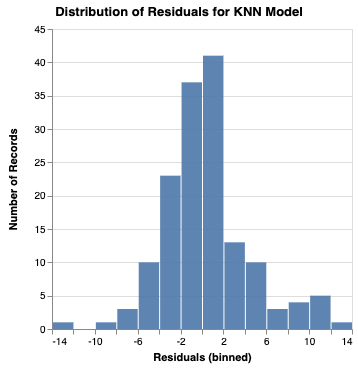

In [40]:
t_pred_knn = fitted_models['KNN'].predict(D_test)
residuals_knn = t_test - t_pred_knn

df_res_knn = pd.DataFrame({'Residuals': residuals_knn})
alt.Chart(df_res_knn, 
          width=300,
          title='Distribution of Residuals for KNN Model'
         ).mark_bar(opacity=0.90).encode(
    alt.X('Residuals', bin=alt.Bin(maxbins=20)),
    alt.Y('count()'))

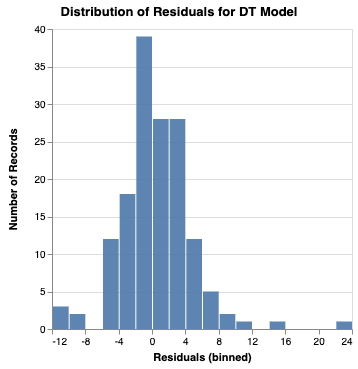

In [41]:
t_pred_dt = fitted_models['DT'].predict(D_test)
residuals_dt = t_test - t_pred_dt

df_res_dt = pd.DataFrame({'Residuals': residuals_dt})
alt.Chart(df_res_dt, 
          width=300,
          title='Distribution of Residuals for DT Model'
         ).mark_bar(opacity=0.90).encode(
    alt.X('Residuals', bin=alt.Bin(maxbins=20)),
    alt.Y('count()'))

KNN residuals are somewhat more tightly distributed compared to that of DT. This might explain why KNN has a lower MSE value.

## Beyond Evaluation  <a class="anchor" id="beyond"></a> 

Data is unlikely to be constant (or stable) forever. For example, consumers change their spending habits and housing prices fluctuate over time. This is known as "concept drift" (Kelleher, Namee & D'Arcy, 2015). Thus, it is important to monitor the model performance in an on-going validation framework. Below are some common approaches to monitor changes in the underlying process:

1. Monitoring changes in model performance metrics.
2. Monitoring model output (target) distribution changes using stability index.
3. Monitoring descriptive feature distribution changes.
4. Conducting comparative experiments using control groups.

We shall not cover model monitoring topics in this tutorial.

# Exercises <a class="anchor" id="exercises"></a> 

1. Using breast cancer data, build a DT model evaluated on **precision** and compute a confusion matrix.
2. Using the DT model from the previous question, compute and visualize a ROC curve.
3. Using the Boston housing data, build and evaluate three regressor models - KNN, DT and (Gaussian) Naive Bayes (NB) using MAE as the metric.

## References

* Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.
* Kelleher, John D., Brian Mac Namee, and Aoife D’Arcy. 2015. Fundamentals of Machine Learning for Predictive Data Analytics: Algorithms, Worked Examples, and Case Studies. MIT Press.

***
www.featureranking.com